# **Finding Lane Lines on the Road** 
***


Lucas Gago
---
December 2016

## Packages:


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
global a,prev_r,prev_l
%matplotlib inline

## Functions:


In [20]:
def perp( a ) :
    
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b


def seg_intersect(a1,a2, b1,b2) :
    
    """line segment a given by endpoints a1, a2
    line segment b given by endpoints b1, b2
    return intersection.From http://www.cs.mun.ca/
    ~rod/2500/notes/numpy-arrays/numpy-arrays.html:
    """
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def grayscale(img):
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):

    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[0, 0, 255], thickness=10):

    right=[]
    left=[]
    global a,prev_r,prev_l,n
    
    #Image base line:
    p1 = np.array( [0.0, img.shape[0]] )
    p2 = np.array( [img.shape[1], img.shape[0]] )
    
    #Horizontal line in the second third of the image:
    p3 = np.array( [0.0, 2*img.shape[0]/3] )
    p4 = np.array( [img.shape[1], 2*img.shape[0]/3] )
    if lines is None:lines=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope= ((y2-y1)/(x2-x1))
            if (.6<abs(slope)<.7):
                pr1 = np.array( [x1, y1] )
                pr2 = np.array( [x2, y2] )
                b_inter=seg_intersect(p1,p2, pr1,pr2)[0]
                t_inter=seg_intersect(p3,p4, pr1,pr2)[0]
                width=img.shape[1]
                
                #Find if line is in range
                if (50<b_inter<width/3 or 2*img.shape[1]/3<b_inter<width-50):
                #and (3*width/8<t_inter<5*width/8):
                    
                    #Check if it is a right or left line and filter bad results
                    # only if we have enough iterations
                    if slope>0 and (prev_r==[] or abs(prev_r[0]-x1)<1000 or n>15) :right.append(line)
                    if slope<0 and (prev_l==[] or abs(prev_l[0]-x1)<1000 or n<15) :left.append(line)
    
    mean=[]
    for i in right:
        
        #Mean of all points
        mean=sum(right)/len(right)
        
    if len(mean):
        
        #Apply exponential filter
        mean=mean.tolist()[0]
        a_prev_r=[a*x for x in prev_r]
        a_mean_r=[(1-a)*x for x in mean]
        prev_r=[x + y for x, y in zip(a_prev_r, a_mean_r)] if prev_r!=[] else mean
        prev_r=list(map(int, prev_r))
        
    if prev_r!=[]:
        pr1 = np.array( prev_r[:2] )
        pr2 = np.array( prev_r[2:] )
        
        # Unify lines lenght
        lower_r= seg_intersect( p1,p2, pr1,pr2)
        upper_r=seg_intersect( p3,p4, pr1,pr2)
        cv2.line(img, (int(lower_r[0]),int(lower_r[1])),(int(upper_r[0]),int(upper_r[1])), color, thickness)


    # Same for the left side
    mean=[]
    for i in left:
        mean=sum(left)/len(left)
        
    if len(mean):
        mean=mean.tolist()[0]
        a_prev_l=[a*x for x in prev_l]
        a_mean_l=[(1-a)*x for x in mean]
        prev_l=[x + y for x, y in zip(a_prev_l, a_mean_l)] if prev_l!=[] else mean
        prev_l=list(map(int, prev_l))
        
    if prev_l!=[]:
        pl1 = np.array(prev_l[:2])
        pl2 = np.array(prev_l[2:])
        lower_l= seg_intersect( p1,p2, pl1,pl2)
        upper_l= seg_intersect( p3,p4, pl1,pl2)
        cv2.line(img, (int(lower_l[0]),int(lower_l[1])),(int(upper_l[0]),int(upper_l[1])), color, thickness)

    n+=1
    


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    
    return cv2.addWeighted(initial_img, α, img, β, λ)


def process_image(image):
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # define range of yellow color in HSV
    lower_y = np.array([20,100,100])
    upper_y = np.array([30, 255, 255])
    
    # define range of white color in HSV
    lower_w = np.array([0,0,150])
    upper_w = np.array([255, 150, 255])
    
    # Threshold the HSV image to get only blue and white colors
    y_mask = cv2.inRange(hsv, lower_y, upper_y)
    w_mask = cv2.inRange(hsv, lower_w, upper_w)

    mask = y_mask + w_mask

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(hsv,hsv, mask= mask)
    
    #Pick third channel of HSV for grayscale
    gray = res[:,:,2]
    
    #Gaussian blur
    blr=gaussian_blur(gray,5)

    #Canny edge detection
    cny=canny(blr,150,200)

    #Select ROI
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(imshape[1]/2-100, imshape[0]/2), (imshape[1]/2+100, imshape[0]/2), (imshape[1]-100,imshape[0])]], dtype=np.int32)
    roigray=region_of_interest(cny,vertices)

    #Parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line
    max_line_gap = 50    # maximum gap in pixels between connectable line segments
    lineas=hough_lines(roigray, rho, theta, threshold, min_line_length, max_line_gap)

    #Get all together
    result=weighted_img(lineas,image)
    
    return result

## Test on Images


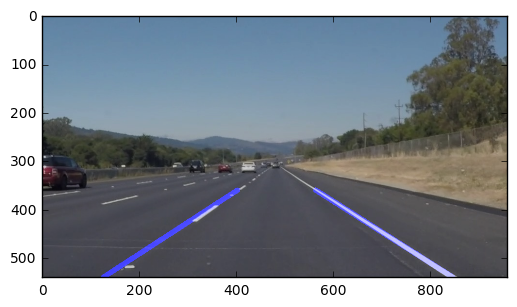

In [21]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
a=.8
n=0
prev_r=prev_l=[]
result=process_image(image)
plt.imshow(result)


## Test on Videos


In [22]:
white_output = 'white.mp4'
a=.8
prev_r=prev_l=[]
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:05<00:00, 42.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 5.74 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [24]:
yellow_output = 'yellow.mp4'
a=.8
prev_r=prev_l=[]
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:16<00:00, 41.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 17 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [26]:
challenge_output = 'extra.mp4'
a=.9
n=0
prev_r=prev_l=[]
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:13<00:00, 18.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 14.9 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
  
</video>
""".format(challenge_output))

## Reflections

After finishing this project, I get to know from first hand how difficult it is to rely only on computer vision techniques. I´m sure that classifiers and basic transformations are going to be useful in the future for focusing our input data into important things.

This algorithm is based on color detection, finding lines and using an exponential filter and an expected ROI for filtering. I'm sure that it's not going to work in difficult conditions like poor lighting, rain or heavy traffic. Also, the distance of our ROI is going to change if we have a pronounced slope in the road.

## More videos

In [28]:
extra_output1 = 'extra1_done.mp4'
a=.9
n=0
prev_r=prev_l=[]
clip2 = VideoFileClip('extra33.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(extra_output1, audio=False)


[MoviePy] >>>> Building video extra1_done.mp4
[MoviePy] Writing video extra1_done.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [00:19<00:00, 22.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra1_done.mp4 

Wall time: 20.5 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
  
  
</video>
""".format(extra_output1))